In [1]:
import numpy as np
import random
import os
import pandas as pd
import cv2
import torch
import torchvision
from xml.etree import ElementTree as et
import shutil

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import argparse

!pip install pytorch_model_summary
!pip install adamp
!pip install torchsummary

from adamp import AdamP
import pytorch_model_summary
import torchsummary

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [5]:
###### DATA ######
old_train_dir = 'train_zip/train'
old_test_dir = 'test_zip/test'
train_img_dir = 'data/images/train'
test_img_dir = 'data/images/valid'
train_label_dir = 'data/labels/train'
test_label_dir = 'data/labels/valid'
fruit_classes = ['apple', 'banana', 'orange']
img_w, img_h = 480, 480

###### MODEL ######
model_name = "Yolov5"
opt_name = "Adam"
lr = 0.001
epoch = 30

In [6]:
!mkdir data
!mkdir data\images
!mkdir data\labels
!mkdir data\images\train
!mkdir data\images\valid
!mkdir data\labels\train
!mkdir data\labels\valid

A subdirectory or file data already exists.
A subdirectory or file data\images already exists.
A subdirectory or file data\labels already exists.
A subdirectory or file data\images\train already exists.
A subdirectory or file data\images\valid already exists.
A subdirectory or file data\labels\train already exists.
A subdirectory or file data\labels\valid already exists.


In [7]:
def get_files_count(folder_path):
    dirListing = os.listdir(folder_path)
    return len(dirListing)

len_train = get_files_count(old_train_dir)
len_test = get_files_count(old_test_dir)
print(f'#train = {len_train}, #test = {len_test}') # 480, 120

train_cnt, test_cnt = 0, 0
for train_file in os.listdir(old_train_dir):
    etc, ext = train_file.split('.')
    if ext == 'jpg':
        dir_from = os.path.join(old_train_dir, train_file)
        img_from = cv2.imread(dir_from, cv2.IMREAD_UNCHANGED)
        img_rgb = cv2.cvtColor(img_from, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (480, 480), cv2.INTER_AREA)
        dir_to = os.path.join(train_img_dir, train_file)
        cv2.imwrite(dir_to, img_from)
        
    if ext == 'xml':
        f = open(os.path.join(train_label_dir, etc + ".txt"), 'w')
        tree = et.parse(os.path.join(old_train_dir, train_file))
        root = tree.getroot()
        
        img_path = os.path.join(old_train_dir, etc + '.jpg')
        img = cv2.imread(img_path)
        width, height = img.shape[1], img.shape[0]
        
        for member in root.findall('object'):
            class_num = str(fruit_classes.index(member.find('name').text))
            xmin = int(member.find('bndbox').find('xmin').text) / width
            xmax = int(member.find('bndbox').find('xmax').text) / width
            ymin = int(member.find('bndbox').find('ymin').text) / height
            ymax = int(member.find('bndbox').find('ymax').text) / height
            
            x_center, y_center = str((xmin + xmax) / 2), str((ymin + ymax) / 2)
            w, h = str(xmax - xmin), str(ymax - ymin)
            f.write(class_num + " " + x_center + " " + y_center + " " + w + " " + h +'\n')
        
        f.close()
    train_cnt += 1
    
for test_file in os.listdir(old_test_dir):
    etc, ext = test_file.split('.')
    if ext == 'jpg':
        dir_from = os.path.join(old_test_dir, test_file)
        img_from = cv2.imread(dir_from, cv2.IMREAD_UNCHANGED)
        img_rgb = cv2.cvtColor(img_from, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (512, 512), cv2.INTER_AREA)
        dir_to = os.path.join(test_img_dir, test_file)
        cv2.imwrite(dir_to, img_from)
        
    if ext == 'xml':
        f = open(os.path.join(test_label_dir, etc + ".txt"), 'w')
        tree = et.parse(os.path.join(old_test_dir, test_file))
        root = tree.getroot()
        img_path = os.path.join(old_test_dir, etc + '.jpg')
        img = cv2.imread(img_path)
        width, height = img.shape[1], img.shape[0]
        for member in root.findall('object'):
            class_num = str(fruit_classes.index(member.find('name').text))
            xmin = int(member.find('bndbox').find('xmin').text) / width
            xmax = int(member.find('bndbox').find('xmax').text) / width
            ymin = int(member.find('bndbox').find('ymin').text) / height
            ymax = int(member.find('bndbox').find('ymax').text) / height
            
            x_center, y_center = str((xmin + xmax) / 2), str((ymin + ymax) / 2)
            w, h = str(xmax - xmin), str(ymax - ymin)
            f.write(class_num + " " + x_center + " " + y_center + " " + w + " " + h +'\n')
        
        f.close()
    test_cnt += 1

#train = 480, #test = 120


In [8]:
new_len_train_img = get_files_count('data/images/train')
new_len_train_label = get_files_count('data/labels/train')
new_len_valid_img = get_files_count('data/images/valid')
new_len_valid_label = get_files_count('data/labels/valid')

print(new_len_train_img, new_len_train_label, new_len_valid_img, new_len_valid_label)

240 240 60 60


In [9]:
class FruitDataset(torch.utils.data.Dataset):
    
    def __init__(self, file_dir, w, h, transforms = None):
        self.transforms = transforms
        self.w = w
        self.h = h
        self.file_dir = file_dir
        self.imgs = [image for image in sorted(os.listdir(file_dir)) if image[-4:] == '.jpg']
        self.classes = ['apple','banana','orange']
        
    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.file_dir, img_name)
        
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.w, self.h), cv2.INTER_AREA)
        img_res = img_res / 255.0 # normalization
        
        xml_name = img_name[:-4] + '.xml'
        xml_path = os.path.join(self.file_dir, xml_name)
        boxes = []
        labels = []
        tree = et.parse(xml_path)
        root = tree.getroot()
        
        img_w = img.shape[1]
        img_h = img.shape[0]
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            x_min = (int(member.find('bndbox').find('xmin').text) / img_w) * self.w
            x_max = (int(member.find('bndbox').find('xmax').text) / img_w) * self.w
            
            y_min = (int(member.find('bndbox').find('ymin').text) / img_h) * self.h
            y_max = (int(member.find('bndbox').find('ymax').text) / img_h) * self.h

            boxes.append([x_min, y_min, x_max, y_max])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = torch.tensor(labels)
        
        if self.transforms:
            sample = self.transforms(image = img_res, bboxes = target["boxes"], labels = labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
        
        img_res = torch.tensor(img_res)
        
        return img_res, idx, target
        
    def __len__(self):
        return len(self.imgs)
        
def get_transform(train):

    if train:
        return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([A.Rotate(limit=10),
                 A.RandomBrightness(),
                 A.Cutout(num_holes=8, max_h_size=1, max_w_size=1, fill_value=1),
                 ], p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def plot_bbox(img, target):
    fig, bbox = plt.subplots(1,1)
    bbox.imshow(img.permute(1, 2, 0))
    
    for box in target["boxes"]:
        x, y, w, h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y), w, h, linewidth = 2, edgecolor = 'r', facecolor = 'none')
        bbox.add_patch(rect)
        
    plt.show()

dataset_length: train = 240, val = 240


C:\Users\User\AppData\Roaming\Python\Python39\site-packages\albumentations\augmentations\transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\albumentations\augmentations\dropout\cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_2484\1069051731.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_res = torch.tensor(img_res)


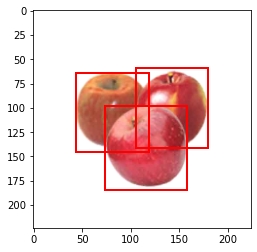

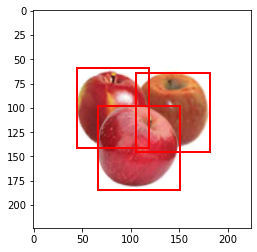

In [10]:
data_train = FruitDataset(old_train_dir, 224, 224, transforms = get_transform(train=True))
data_val = FruitDataset(old_train_dir, 224, 224, transforms = get_transform(train=False))

img_train, idx_train, target_train = data_train[15]
img_val, idx_val, target_val = data_val[15]

print(f'dataset_length: train = {len(data_train)}, val = {len(data_val)}')

plot_bbox(img_train, target_train)
plot_bbox(img_val, target_val)

In [11]:
import yaml

data_yaml = dict(
    train = 'data/images/train',
    val = 'data/images/train',
    nc = 3,
    names = ['apple','banana','orange']
)

with open('data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

In [12]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...


In [24]:
!cd yolov5 && python train.py --img 512 --batch 16 --epochs 20 --data data.yaml --weights yolov5s.pt --workers 2

wandb: Currently logged in as: anony-mouse-466016. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=data.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-49-g3c1afd9 Python-3.9.12 torch-1.8.1+cu111 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.

      16/19         0G    0.03392    0.02544   0.006545         66        512:  20%|##        | 3/15 [00:15<01:00,  5.04s/it]
      16/19         0G    0.03352    0.02434    0.00693         61        512:  20%|##        | 3/15 [00:20<01:00,  5.04s/it]
      16/19         0G    0.03352    0.02434    0.00693         61        512:  27%|##6       | 4/15 [00:20<00:55,  5.06s/it]
      16/19         0G    0.03479    0.02544   0.007137         81        512:  27%|##6       | 4/15 [00:25<00:55,  5.06s/it]
      16/19         0G    0.03479    0.02544   0.007137         81        512:  33%|###3      | 5/15 [00:25<00:51,  5.14s/it]
      16/19         0G    0.03489    0.02465   0.006591         63        512:  33%|###3      | 5/15 [00:30<00:51,  5.14s/it]
      16/19         0G    0.03489    0.02465   0.006591         63        512:  40%|####      | 6/15 [00:30<00:45,  5.11s/it]
      16/19         0G    0.03523    0.02446   0.006067         64        512:  40%|####      | 6/15 [00:35<00:45,  5.

In [25]:
!cd yolov5 && python train.py --img 512 --batch 16 --epochs 50 --data data.yaml --weights yolov5s.pt --workers 2

wandb: Currently logged in as: anony-mouse-466016. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=data.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-49-g3c1afd9 Python-3.9.12 torch-1.8.1+cu111 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.

       9/49         0G     0.0516    0.02691   0.009201         86        512:  53%|#####3    | 8/15 [00:46<00:35,  5.13s/it]
       9/49         0G     0.0516    0.02691   0.009201         86        512:  60%|######    | 9/15 [00:46<00:30,  5.09s/it]
       9/49         0G    0.05196    0.02667   0.008979         65        512:  60%|######    | 9/15 [00:51<00:30,  5.09s/it]
       9/49         0G    0.05196    0.02667   0.008979         65        512:  67%|######6   | 10/15 [00:51<00:25,  5.06s/it]
       9/49         0G    0.05196    0.02644   0.009468         62        512:  67%|######6   | 10/15 [00:56<00:25,  5.06s/it]
       9/49         0G    0.05196    0.02644   0.009468         62        512:  73%|#######3  | 11/15 [00:56<00:20,  5.05s/it]
       9/49         0G    0.05284    0.02688   0.009355         81        512:  73%|#######3  | 11/15 [01:01<00:20,  5.05s/it]
       9/49         0G    0.05284    0.02688   0.009355         81        512:  80%|########  | 12/15 [01:01<00:15

In [26]:
!cd yolov5 && python train.py --img 512 --batch 16 --epochs 100 --data data.yaml --weights yolov5s.pt --workers 2

wandb: Currently logged in as: anony-mouse-466016. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=data.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-49-g3c1afd9 Python-3.9.12 torch-1.8.1+cu111 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size

  0%|          | 0/15 [00:00<?, ?it/s]
       9/99         0G    0.05467    0.02546    0.01284         59        512:   0%|          | 0/15 [00:04<?, ?it/s]
       9/99         0G    0.05467    0.02546    0.01284         59        512:   7%|6         | 1/15 [00:04<01:08,  4.87s/it]
       9/99         0G    0.05563    0.02924    0.01333         81        512:   7%|6         | 1/15 [00:09<01:08,  4.87s/it]
       9/99         0G    0.05563    0.02924    0.01333         81        512:  13%|#3        | 2/15 [00:09<01:03,  4.90s/it]
       9/99         0G    0.05407    0.02728    0.01233         66        512:  13%|#3        | 2/15 [00:14<01:03,  4.90s/it]
       9/99         0G    0.05407    0.02728    0.01233         66        512:  20%|##        | 3/15 [00:14<00:58,  4.86s/it]
       9/99         0G    0.05363    0.02581    0.01247         54        512:  20%|##        | 3/15 [00:19<00:58,  4.86s/it]
       9

  0%|          | 0/15 [00:00<?, ?it/s]
      81/99         0G    0.02525    0.01949   0.001552         83        512:   0%|          | 0/15 [00:04<?, ?it/s]
      81/99         0G    0.02525    0.01949   0.001552         83        512:   7%|6         | 1/15 [00:04<01:09,  4.99s/it]
      81/99         0G    0.02597    0.01771   0.002152         66        512:   7%|6         | 1/15 [00:09<01:09,  4.99s/it]
      81/99         0G    0.02597    0.01771   0.002152         66        512:  13%|#3        | 2/15 [00:09<01:03,  4.90s/it]
      81/99         0G    0.02413    0.01802   0.001714         83        512:  13%|#3        | 2/15 [00:14<01:03,  4.90s/it]
      81/99         0G    0.02413    0.01802   0.001714         83        512:  20%|##        | 3/15 [00:14<00:58,  4.90s/it]
      81/99         0G    0.02334    0.01715   0.001589         54        512:  20%|##        | 3/15 [00:19<00:58,  4.90s/it]
      81/99         0G    0.02334    0.01715   0.001589         54        512:  27%|##6

      94/99         0G    0.01894     0.0174   0.002316         77        512:  20%|##        | 3/15 [00:14<00:58,  4.90s/it]
      94/99         0G    0.01895    0.01736   0.001888         75        512:  20%|##        | 3/15 [00:19<00:58,  4.90s/it]
      94/99         0G    0.01895    0.01736   0.001888         75        512:  27%|##6       | 4/15 [00:19<00:53,  4.87s/it]
      94/99         0G    0.01925    0.01787   0.001608         89        512:  27%|##6       | 4/15 [00:24<00:53,  4.87s/it]
      94/99         0G    0.01925    0.01787   0.001608         89        512:  33%|###3      | 5/15 [00:24<00:49,  4.91s/it]
      94/99         0G    0.01934    0.01804   0.001488         83        512:  33%|###3      | 5/15 [00:29<00:49,  4.91s/it]
      94/99         0G    0.01934    0.01804   0.001488         83        512:  40%|####      | 6/15 [00:29<00:44,  4.91s/it]
      94/99         0G    0.01914    0.01754   0.001393         61        512:  40%|####      | 6/15 [00:34<00:44,  4.